# DeepFake Detection: Base Model

**Objective**: Develop a base CNN model for DeepFake detection to use as baseline accuracy which can later be compared with other transfer learning models

**Base Models**: develop 2 types of base models:
1. Binary Classification
2. Multiclass Classification

In [1]:
import numpy as np
% matplotlib inline
from __future__ import print_function

#Data Processing
from skimage import io
import os
import glob
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import random
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

#Neural Networks
from tensorflow.python import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam

#Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model

#Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint,Callback
from sklearn import metrics
from tensorflow.keras.models import load_model

Using TensorFlow backend.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-pa

## Dataset Split

Load the DeepFake dataset to randomly divide it into train and test set 

In [2]:
# path to your dataset
DATASET_PATH = '/mnt/disks/user/project/Dataset/'
deepfake_class = ['original/clean_frames','FaceSwap/clean_frames', 'Reenactment/clean_frames']

In [3]:
'''
func: load the deepfake dataset and divide them into train and test with each having samples of the different classes
input:
    i.dataset_path: string: the main dataset folder path 
    ii.train_ratio: float: the ratio of the dataset that will be used for training the model. Eg: 0.8
    iii. fake_class: string array: the different deepfake classes
output:
    i. train_set, test_set: dictionary of image paths as key and deepfake class as value
    ii. X_train, X_test: array of image paths 
    iii. y_train, y_test: array of corresponding deepfake classes 
'''
def MultiDatasetSplit(DATASET_PATH, train_ratio,fake_cls):
    test_set = {}
    train_set = {}
    list_IDs = []
    labels = {}
    for i, cls in enumerate(fake_cls):
        paths = glob.glob(os.path.join(DATASET_PATH, cls,'*/*.jpg'))
        #balancing the dataset
        balance_paths = random.sample(paths,1000)

        brk_point = int(len(balance_paths)*train_ratio)
        for j in range(len(balance_paths)):
            if j <= brk_point:
                train_set.update({balance_paths[j]:i})
            else:
                test_set.update({balance_paths[j]:i})
    
    X_train = [X for X in train_set.keys()] 
    y_train = [y for y in train_set.values()]
    X_test = [X for X in test_set.keys()]
    y_test = [y for y in test_set.values()]
    return train_set, test_set, X_train,y_train, X_test, y_test

In [4]:
'''
func: load the deepfake dataset and divide them into train and test with each having samples of the different classes
input:
    i.dataset_path: string: the main dataset folder path 
    ii.train_ratio: float: the ratio of the dataset that will be used for training the model. Eg: 0.8
    iii. fake_class: string array: the different deepfake classes
output:
    i. train_set, test_set: dictionary of image paths as key and deepfake class as value
    ii. X_train, X_test: array of image paths 
    iii. y_train, y_test: array of corresponding deepfake classes 
'''
def BinaryDatasetSplit(DATASET_PATH, train_ratio,fake_cls):
    test_set = {}
    train_set = {}
    list_IDs = []
    labels = {}
    for i, cls in enumerate(fake_cls):
        paths = glob.glob(os.path.join(DATASET_PATH, cls,'*/*.jpg'))
        brk_point = int(len(paths)*train_ratio)
        for j in range(len(paths)):
            if j <= brk_point:
                if i == 0:
                    train_set.update({paths[j]:0})
                else: 
                    train_set.update({paths[j]:1})
            else:
                if i == 0:
                    test_set.update({paths[j]:0})
                else:
                    test_set.update({paths[j]:1})

    X_train = [X for X in train_set.keys()] 
    y_train = [y for y in train_set.values()]
    X_test = [X for X in test_set.keys()]
    y_test = [y for y in test_set.values()]
    return train_set, test_set, X_train,y_train, X_test, y_test

In [5]:
b_train_set, b_test_set, b_train_X, b_train_y, b_test_X, b_test_y = BinaryDatasetSplit(DATASET_PATH,0.7,deepfake_class)

In [6]:
m_train_set, m_test_set, m_train_X, m_train_y, m_test_X, m_test_y = MultiDatasetSplit(DATASET_PATH,0.7,deepfake_class)

In [7]:
Counter(b_train_set.values())

Counter({0: 15435, 1: 17764})

In [8]:
Counter(m_train_set.values())

Counter({0: 701, 1: 701, 2: 701})

In [9]:
set(b_test_set.values())

{0, 1}

In [10]:
set(m_test_set.values())

{0, 1, 2}

In [11]:
# specify image size and channels
img_channels = 3
img_rows = 224
img_cols = 224

# number of classes
b_nb_classes = 2
m_nb_classes = 3

## Data Processing

Divide data into batches and process them

In [12]:
'''
func: prepare and process batch wise data for training/ablation. 
The image path is converted to image data while the classes are label encoded (0,1,2)
input:
    i.image_list: X data: array of image paths
    ii:classes: y data: dictionary of image paths and their corresponding classes
output:
    i. DataGenerator
'''
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, image_list, classes, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=3,shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.classes = classes
        self.image_list = image_list
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_img_temp = [self.image_list[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_img_temp)
        return X, y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_img_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization of Y
        y = np.empty((self.batch_size), dtype=int)
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        #X = np.random.rand(self.batch_size, *self.dim, self.n_channels)

        #For each image path in the batch: load it, convert it to array, normalize values and pre-process.
        #Append X and respective y values to the empty X and y variables
        for i, ID in enumerate(list_img_temp):
            img = load_img(ID, target_size=self.dim)
            img = img_to_array(img)
            img = img/255
            #img = preprocess_input(img)
            X[i,] = img
            y[i] = self.classes[ID]
            
        #class encoding to 0,1,2
#         le = LabelEncoder()
#         self.y_value = le.fit_transform(y)
        return X,keras.utils.to_categorical(y, num_classes=self.n_classes)

In [13]:
'''
func: get the data generators for training and validation
input:
    i.train_X, test_X: array of image paths in training and testing respectively
    ii.train_set, test_set: dictionary of image paths and their corresponding class for training and test data respectively
    iii. ablation: int: number of training and test entries to use for DataGeneration
output:
    i. training_generator
    ii. validation_generator
'''
def data_generator(train_X, train_set, test_X, test_set,classes,ablation = None):
    #Randomly selecting data in case of ablation testing
    if ablation != None:
        train_X = random.sample(train_X, ablation)
        train_set = {image: train_set[image] for image in train_X }
        test_X = random.sample(test_X, ablation)
        test_set = {image: test_set[image] for image in test_X }
    training_generator = DataGenerator(train_X, train_set,n_classes=classes)
    validation_generator = DataGenerator(test_X, test_set,n_classes=classes)
    return training_generator,validation_generator

In [14]:
from sklearn.metrics import roc_auc_score

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

## Binary Base Classification Models

In [15]:
def cnn_model(in_shape=(224,224,3)):
    model = Sequential()
    model.add(Conv2D(64,(3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64,(3,3),strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(b_nb_classes, activation='sigmoid'))
    return model

#call define model
binary_base_model = cnn_model()

In [16]:
training_generator, validation_generator = data_generator(b_train_X, b_train_set, b_test_X, b_test_set,classes=b_nb_classes)
binary_base_model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [17]:
# checkpoint 
binary_filepath = '/mnt/disks/user/project/Final_Models/base_binary_best_model.hdf5'
checkpoint = ModelCheckpoint(binary_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
auc_logger = roc_callback()
# fit: this will fit the net on 'ablation' samples, only 1 epoch
binary_history = binary_base_model.fit_generator(generator = training_generator,
                    validation_data = validation_generator,
                    shuffle=True,
                    epochs=20,
                    callbacks=[checkpoint,auc_logger])

Epoch 1/20
1036/1037 [============================>.] - ETA: 0s - loss: 0.6874 - acc: 0.5403
Epoch 00001: val_acc improved from -inf to 0.51570, saving model to /mnt/disks/user/project/Final_Models/base_binary_best_model.hdf5

Val AUC for epoch0: 0.5324951844561372
1037/1037 [==============================] - 1419s 1s/step - loss: 0.6873 - acc: 0.5404 - val_loss: 0.6951 - val_acc: 0.5157
Epoch 2/20
1036/1037 [============================>.] - ETA: 0s - loss: 0.6801 - acc: 0.5576
Epoch 00002: val_acc did not improve from 0.51570

Val AUC for epoch1: 0.516053860324398
1037/1037 [==============================] - 259s 250ms/step - loss: 0.6801 - acc: 0.5576 - val_loss: 0.6947 - val_acc: 0.5128
Epoch 3/20
1036/1037 [============================>.] - ETA: 0s - loss: 0.6719 - acc: 0.5773
Epoch 00003: val_acc improved from 0.51570 to 0.52280, saving model to /mnt/disks/user/project/Final_Models/base_binary_best_model.hdf5

Val AUC for epoch2: 0.5006016709621733
1037/1037 [====================

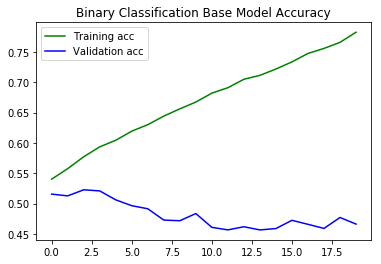

In [18]:
binary_acc = binary_history.history['acc']
binary_val_acc = binary_history.history['val_acc']

binary_epochs = range(len(binary_acc))

plt.plot(binary_epochs, binary_acc, 'g', label='Training acc')
plt.plot(binary_epochs, binary_val_acc, 'b', label='Validation acc')
plt.title('Binary Classification Base Model Accuracy')
plt.legend()

### Binary Base Model Evaluation

In [19]:
binary_test_generator = DataGenerator(b_test_X, b_test_set,n_classes=2,shuffle=False)

In [20]:
#Load the best model
binary_eval_base_model = load_model(binary_filepath)

In [21]:
binary_predictions = binary_eval_base_model.predict_generator(binary_test_generator)

In [22]:
binary_y_class = np.array(list(binary_test_generator.classes.values()))[:len(binary_predictions)]
binary_y = keras.utils.to_categorical(binary_y_class, num_classes=b_nb_classes)

In [23]:
binary_prob_max = binary_predictions.max(axis=1).reshape(-1, 1)
binary_y_pred = np.where(binary_predictions == binary_prob_max, 1, 0)

In [24]:
binary_pred = np.argmax(binary_predictions, axis=-1)

In [25]:
len(binary_y_pred)

14208

In [26]:
len(binary_y)

14208

In [27]:
Counter(binary_pred)

Counter({0: 3986, 1: 10222})

In [28]:
binary_score_test = metrics.accuracy_score(binary_y, binary_y_pred)
print('Base Model Test Score ',binary_score_test)

Base Model Test Score  0.5230855855855856


In [29]:
binary_cm = confusion_matrix(binary_y_class, binary_pred)
print(binary_cm)

[[1912 4702]
 [2074 5520]]


In [30]:
binary_report = classification_report(binary_y,binary_y_pred)
print(binary_report)

             precision    recall  f1-score   support

          0       0.48      0.29      0.36      6614
          1       0.54      0.73      0.62      7594

avg / total       0.51      0.52      0.50     14208



## Multi-Class Base Classification Models

In [31]:
def cnn_model(in_shape=(224,224,3)):
    model = Sequential()
    model.add(Conv2D(64,(3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64,(3,3),strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(m_nb_classes, activation='softmax'))
    return model

#call define model
multi_base_model = cnn_model()

In [32]:
m_training_generator, m_validation_generator = data_generator(m_train_X, m_train_set, m_test_X, m_test_set,classes=m_nb_classes)
multi_base_model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [33]:
# checkpoint 
multi_filepath = '/mnt/disks/user/project/Final_Models/base_multi_best_model.hdf5'
checkpoint = ModelCheckpoint(multi_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
auc_logger = roc_callback()
# fit: this will fit the net on 'ablation' samples, only 1 epoch
multi_history = multi_base_model.fit_generator(generator = m_training_generator,
                    validation_data = m_validation_generator,
                    shuffle=True,
                    epochs=20,
                    callbacks=[checkpoint])

Epoch 1/20
64/65 [============================>.] - ETA: 0s - loss: 1.1081 - acc: 0.3755
Epoch 00001: val_acc improved from -inf to 0.45759, saving model to /mnt/disks/user/project/Final_Models/multi_binary_best_model.hdf5
65/65 [==============================] - 12s 181ms/step - loss: 1.1078 - acc: 0.3764 - val_loss: 1.0670 - val_acc: 0.4576
Epoch 2/20
64/65 [============================>.] - ETA: 0s - loss: 1.0564 - acc: 0.4375
Epoch 00002: val_acc did not improve from 0.45759
65/65 [==============================] - 11s 165ms/step - loss: 1.0563 - acc: 0.4380 - val_loss: 1.0515 - val_acc: 0.4431
Epoch 3/20
64/65 [============================>.] - ETA: 0s - loss: 1.0402 - acc: 0.4502
Epoch 00003: val_acc improved from 0.45759 to 0.50000, saving model to /mnt/disks/user/project/Final_Models/multi_binary_best_model.hdf5
65/65 [==============================] - 11s 165ms/step - loss: 1.0410 - acc: 0.4495 - val_loss: 1.0349 - val_acc: 0.5000
Epoch 4/20
64/65 [============================

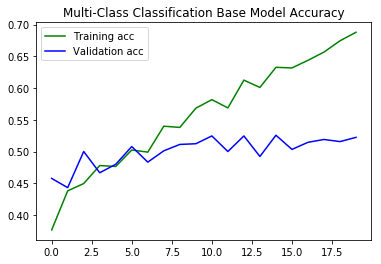

In [34]:
multi_acc = multi_history.history['acc']
multi_val_acc = multi_history.history['val_acc']

multi_epochs = range(len(multi_acc))

plt.plot(multi_epochs, multi_acc, 'g', label='Training acc')
plt.plot(multi_epochs, multi_val_acc, 'b', label='Validation acc')
plt.title('Multi-Class Classification Base Model Accuracy')
plt.legend()

### Multi-Class Base Model Evaluation

In [35]:
multi_test_generator = DataGenerator(m_test_X, m_test_set,n_classes=m_nb_classes,shuffle=False)

In [36]:
#Load the best model
multi_eval_base_model = load_model(multi_filepath)

In [37]:
multi_predictions = multi_eval_base_model.predict_generator(multi_test_generator)

In [38]:
multi_y_class = np.array(list(multi_test_generator.classes.values()))[:len(multi_predictions)]
multi_y = keras.utils.to_categorical(multi_y_class, num_classes=m_nb_classes)

In [39]:
multi_prob_max = multi_predictions.max(axis=1).reshape(-1, 1)
multi_y_pred = np.where(multi_predictions == multi_prob_max, 1, 0)

In [40]:
multi_pred = np.argmax(multi_predictions, axis=-1)

In [41]:
len(multi_y_pred)

896

In [42]:
len(multi_y)

896

In [43]:
Counter(multi_pred)

Counter({1: 379, 0: 144, 2: 373})

In [44]:
multi_score_test = metrics.accuracy_score(multi_y, multi_y_pred)
print('Multi-Class Base Model Test Score ',multi_score_test)

Multi-Class Base Model Test Score  0.5256696428571429


In [45]:
multi_cm = confusion_matrix(multi_y_class, multi_pred)
print(multi_cm)

[[ 65 122 112]
 [ 42 201  56]
 [ 37  56 205]]


In [46]:
multi_report = classification_report(multi_y,multi_y_pred)
print(multi_report)

             precision    recall  f1-score   support

          0       0.45      0.22      0.29       299
          1       0.53      0.67      0.59       299
          2       0.55      0.69      0.61       298

avg / total       0.51      0.53      0.50       896

